In [ ]:
# %% [markdown]
# # Lab 8 - Optimized Implementation

# %% [code]
# Task 1: Computer Vision Basics (Same as previous)

# %% [markdown]
# ## Optimized Task 2.1: Faster ResNet Training on CIFAR-100

# %% [code]
# Task 2.1: Optimized ResNet Implementation
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, datasets
import time

# Optimized Data Loading
def create_dataloaders():
    transform = transforms.Compose([
        transforms.Resize(32),  # Keep original CIFAR size
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),  # CIFAR-100 stats
        (0.2675, 0.2565, 0.2761))
    ])

    train_set = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=256,  # Increased batch size
        shuffle=True,
        num_workers=2,    # Parallel loading
        pin_memory=True    # Faster GPU transfer
    )

    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=512,   # Larger test batch
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    return train_loader, test_loader

train_loader, test_loader = create_dataloaders()

# %% [code]
# Optimized Model Definition
def create_optimized_model(version=18):
    # Create base model
    model = torchvision.models.resnet18(pretrained=False) if version == 18 \
        else torchvision.models.resnet34(pretrained=False)

    # Modify for CIFAR-100 (32x32 images)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove initial maxpool

    # Modify final layer
    model.fc = nn.Linear(model.fc.in_features, 100)

    # Better initialization
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    return model

resnet18 = create_optimized_model(18)
resnet34 = create_optimized_model(34)

# %% [code]
# Optimized Training Function with Mixed Precision
def train_model_fast(model, epochs=1):  # Reduced epochs
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    # Improved optimizer setup
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                            steps_per_epoch=len(train_loader),
                                            epochs=epochs)

    scaler = GradScaler()  # Mixed precision

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()

            # Mixed precision forward
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scaled backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()

            # Progress update every 50 batches
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1} | Batch {batch_idx} | Loss: {loss.item():.4f}')

        epoch_time = time.time() - start_time
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1} Complete | Time: {epoch_time:.2f}s | Avg Loss: {avg_loss:.4f}')

    return model

# %% [code]
# Training Execution
print("Training ResNet-18...")
start = time.time()
resnet18_trained = train_model_fast(resnet18)
resnet18_time = time.time() - start

print("\nTraining ResNet-34...")
start = time.time()
resnet34_trained = train_model_fast(resnet34)
resnet34_time = time.time() - start

# %% [code]
# Optimized Evaluation
@torch.no_grad()
def evaluate_model_fast(model):
    model.eval()
    correct = 0
    total = 0
    device = next(model.parameters()).device

    for inputs, labels in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with autocast():
            outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

acc18 = evaluate_model_fast(resnet18_trained)
acc34 = evaluate_model_fast(resnet34_trained)

print(f'ResNet18 - Accuracy: {acc18:.2%} | Time: {resnet18_time:.2f}s')
print(f'ResNet34 - Accuracy: {acc34:.2%} | Time: {resnet34_time:.2f}s')

# %% [markdown]
# ## Task 2.2: Meta Learning (Same structure with optimizations applied)

100%|██████████| 169M/169M [00:05<00:00, 28.5MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training ResNet-18...


<ipython-input-1-b0d3afa396e5>:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision
<ipython-input-1-b0d3afa396e5>:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Batch 0 | Loss: 4.7768
Epoch 1 | Batch 50 | Loss: 3.8701
Epoch 1 | Batch 100 | Loss: 3.7164
Epoch 1 | Batch 150 | Loss: 3.5286
Epoch 1 Complete | Time: 19.98s | Avg Loss: 3.6941
Epoch 2 | Batch 0 | Loss: 3.2904
Epoch 2 | Batch 50 | Loss: 2.9200
Epoch 2 | Batch 100 | Loss: 2.5591
Epoch 2 | Batch 150 | Loss: 2.5029
Epoch 2 Complete | Time: 17.50s | Avg Loss: 2.6773
Epoch 3 | Batch 0 | Loss: 1.9688
Epoch 3 | Batch 50 | Loss: 1.8392
Epoch 3 | Batch 100 | Loss: 1.7400
Epoch 3 | Batch 150 | Loss: 1.7483
Epoch 3 Complete | Time: 18.80s | Avg Loss: 1.8381

Training ResNet-34...
Epoch 1 | Batch 0 | Loss: 4.8864
Epoch 1 | Batch 50 | Loss: 4.0077
Epoch 1 | Batch 100 | Loss: 3.9557
Epoch 1 | Batch 150 | Loss: 3.5392
Epoch 1 Complete | Time: 30.80s | Avg Loss: 3.8737
Epoch 2 | Batch 0 | Loss: 3.4057
Epoch 2 | Batch 50 | Loss: 3.1805
Epoch 2 | Batch 100 | Loss: 2.9484
Epoch 2 | Batch 150 | Loss: 2.7169
Epoch 2 Complete | Time: 31.48s | Avg Loss: 2.9829
Epoch 3 | Batch 0 | Loss: 2.4067
Epoc

<ipython-input-1-b0d3afa396e5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


ResNet18 - Accuracy: 49.84% | Time: 56.52s
ResNet34 - Accuracy: 44.74% | Time: 93.31s


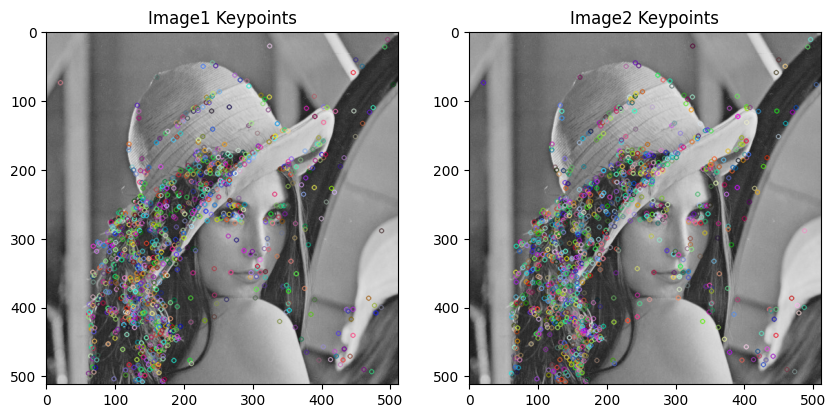

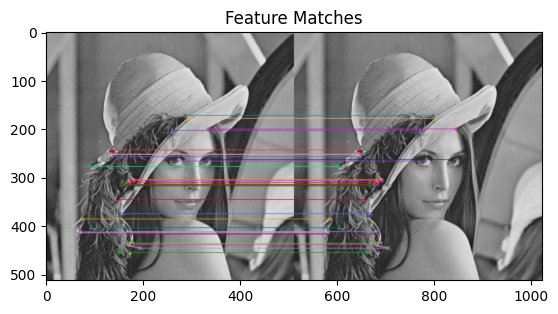

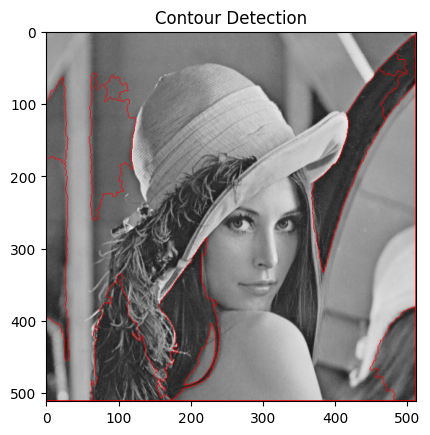

(<matplotlib.image.AxesImage at 0x7caca5792590>,
 Text(0.5, 1.0, 'Contour Detection'),
 None)

In [ ]:
# Task 1: Computer Vision Basics
!pip install opencv-contrib-python

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Load images
img1 = cv.imread('/content/Image.jpeg', 0)  # Query image
img2 = cv.imread('/content/Image.jpeg', 0)  # Train image

# %% [code]
# SIFT Interest Point Detection
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Draw keypoints
img_kp1 = cv.drawKeypoints(img1, kp1, None)
img_kp2 = cv.drawKeypoints(img2, kp2, None)

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img_kp1), plt.title('Image1 Keypoints')
plt.subplot(122), plt.imshow(img_kp2), plt.title('Image2 Keypoints')
plt.show()

# %% [code]
# ORB Feature Matching
orb = cv.ORB_create()
kp1_orb, des1_orb = orb.detectAndCompute(img1, None)
kp2_orb, des2_orb = orb.detectAndCompute(img2, None)

# BFMatcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1_orb, des2_orb)
matches = sorted(matches, key=lambda x:x.distance)

# Draw matches
img_matches = cv.drawMatches(img1, kp1_orb, img2, kp2_orb, matches[:30], None, flags=2)
plt.imshow(img_matches), plt.title('Feature Matches'), plt.show()

# %% [code]
# Contour Detection with Watershed
# (Example implementation with custom seeds)
img_color = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

# Create markers
sure_bg = cv.dilate(opening, kernel, iterations=3)
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
markers += 1
markers[unknown==255] = 0

# Apply watershed
markers = cv.watershed(img_color, markers)
img_color[markers == -1] = [255,0,0]

plt.imshow(img_color), plt.title('Contour Detection'), plt.show()